In [5]:
# Imports and utilities

import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
import scipy.stats as ss
import ot
from tqdm import trange
np.random.seed(42)

Loading libraries...
Libraries loaded.


In [6]:
class TargetGaussian:
    def __init__(self, mean, cov):
        self.mean = np.asarray(mean)
        self.cov = np.asarray(cov)
        self.dim = self.mean.size
        self.inv_cov = np.linalg.inv(self.cov)
        self.norm_const = np.sqrt((2*np.pi)**self.dim * np.linalg.det(self.cov))

    def logpdf(self, x):
        # x: (n_points, dim)
        x = np.atleast_2d(x)
        d = x - self.mean
        vals = -0.5 * np.sum(d @ self.inv_cov * d, axis=1)
        return vals - 0.5 * self.dim * np.log(2*np.pi) - 0.5 * np.log(np.linalg.det(self.cov))

    def grad_logpdf(self, x):
        # returns gradient of logpdf at x: (n_points, dim)
        x = np.atleast_2d(x)
        return - (x - self.mean) @ self.inv_cov

# Default target: standard 2D Gaussian
target = TargetGaussian(mean=[0.0, 0.0], cov=np.eye(2))

# Utilities for KDE and gradient of log KDE via finite differences

def fit_kde(samples, bandwidth=0.3):
    # samples: (m, d)
    kde = KernelDensity(bandwidth=bandwidth)
    kde.fit(samples)
    return kde


def logpdf_kde(kde, x):
    # x: (n, d)
    return kde.score_samples(np.atleast_2d(x))


def grad_logpdf_kde(kde, x, eps=1e-3):
    # finite-difference gradient of logpdf at points x
    # returns (n, d) array
    x = np.atleast_2d(x)
    n, d = x.shape
    grads = np.zeros((n, d))
    base = kde.score_samples(x)
    for k in range(d):
        e = np.zeros(d)
        e[k] = eps
        plus = kde.score_samples(x + e)
        minus = kde.score_samples(x - e)
        grads[:, k] = (plus - minus) / (2 * eps)
    return grads

In [7]:
# Wasserstein discrepancy between component empirical measures
# Here we approximate W2^2 between two empirical point clouds with uniform weights

print("Defining Wasserstein discrepancy utility...")
def empirical_w2_squared(X, Y):
    # X, Y: (m, d)
    m, d = X.shape
    a = np.ones(m) / m
    b = np.ones(m) / m
    M = ot.dist(X, Y, metric='euclidean')**2
    w2 = ot.emd2(a, b, M)
    return w2

Defining Wasserstein discrepancy utility...


In [8]:
def gaussian_sampler(mean, cov, m):
    return np.random.multivariate_normal(mean, cov, size=m)

def laplace_sampler(mean, scale, m):
    # isotropic Laplace (independent coordinates)
    d = len(mean)
    u = np.random.laplace(loc=0.0, scale=scale, size=(m, d))
    return u + np.asarray(mean)

print("Constructing initial components...")
# Construct N components
N = 6
m = 400  # samples per component
dim = 2

# Example: mixture of Gaussians with random means
component_means = np.random.randn(N, dim) * 3.0
component_cov = 0.5 * np.eye(dim)  # fixed covariance for Gaussian components

print("Creating samplers and initial samples for components...")
samplers = []
init_samples = []
for i in range(N):
    mean = component_means[i]
    def make_sampler(mean=mean):
        return lambda m, mean=mean: gaussian_sampler(mean, component_cov, m)
    samplers.append(make_sampler(mean))
    init_samples.append(samplers[-1](m))

# Convert to array: components x samples x dim
components = [s for s in init_samples]

# Parameters for optimization
bandwidth = 0.4
eps = 1e-3
eta = 0.2
n_steps = 120

# Tracking
loss_history = []
w2_history = []
means_history = []

# Initial means
means = np.array([X.mean(axis=0) for X in components])
means_history.append(means.copy())

Constructing initial components...
Creating samplers and initial samples for components...


In [9]:
# Main loop: pathwise updates
for t in trange(n_steps, desc='steps'):
    # compute KL divergence per component and total
    kl_per_comp = []
    w2_per_comp = []
    new_components = []

    for i, X in enumerate(components):
        # Fit KDE for the current component
        kde = fit_kde(X, bandwidth=bandwidth)

        # Compute log densities for KL estimate
        log_p_emp = logpdf_kde(kde, X)
        log_p_target = target.logpdf(X)
        kl_est = np.mean(log_p_emp - log_p_target)
        kl_per_comp.append(kl_est)

        # compute gradients of log densities at sample points
        grad_log_emp = grad_logpdf_kde(kde, X, eps=eps)
        grad_log_target = target.grad_logpdf(X)

        # velocity field: grad log rho - grad log target
        v = grad_log_emp - grad_log_target

        # Update samples
        X_new = X - eta * v

        # store
        new_components.append(X_new)

        # compute W2 between old and new empirical (pathwise movement)
        w2sq = empirical_w2_squared(X, X_new)
        w2_per_comp.append(w2sq)

    # replace
    components = new_components

    # record
    loss_history.append(np.mean(kl_per_comp))
    w2_history.append(np.mean(w2_per_comp))
    means = np.array([X.mean(axis=0) for X in components])
    means_history.append(means.copy())

steps: 100%|██████████| 120/120 [00:36<00:00,  3.26it/s]


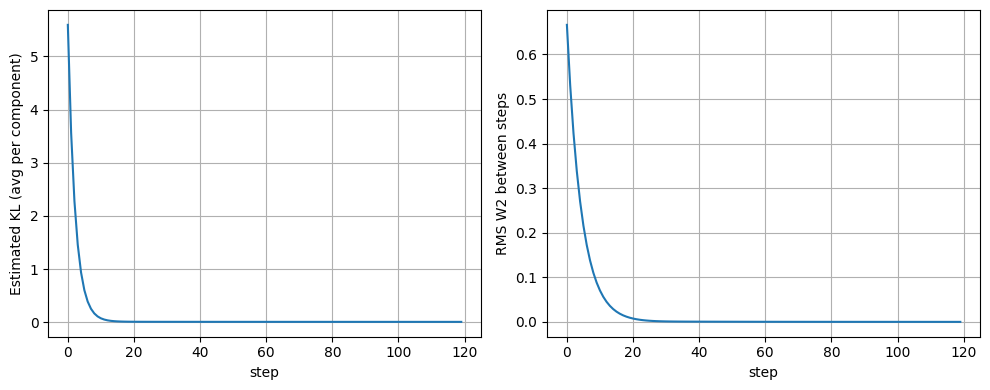

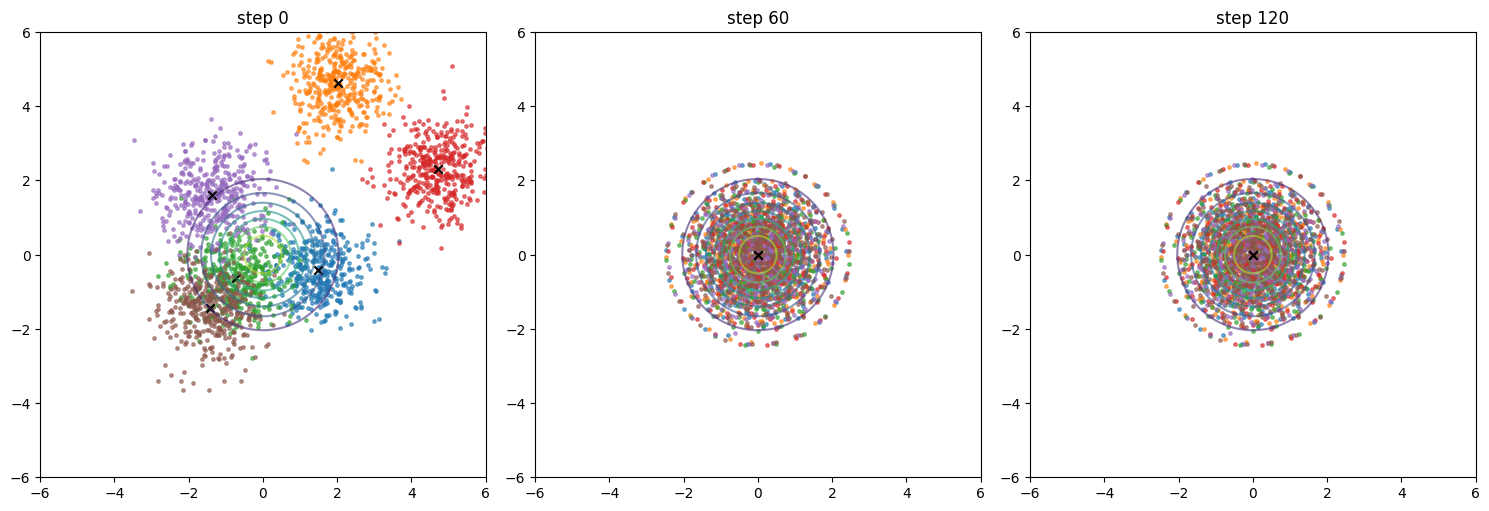

In [10]:
# Plot loss and W2 discrepancy curves
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(loss_history)
plt.xlabel('step')
plt.ylabel('Estimated KL (avg per component)')
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(np.sqrt(w2_history))
plt.xlabel('step')
plt.ylabel('RMS W2 between steps')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot particle clouds pathwise: initial -> intermediate -> final
import matplotlib.cm as cm

steps_to_show = [0, n_steps//2, n_steps]
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
all_hist_means = np.array(means_history)

# build grid for target density contour
xx = np.linspace(-6, 6, 200)
yy = np.linspace(-6, 6, 200)
Xg, Yg = np.meshgrid(xx, yy)
grid = np.vstack([Xg.ravel(), Yg.ravel()]).T
Z = np.exp(target.logpdf(grid)).reshape(Xg.shape)

for ax, step in zip(axes.flat, steps_to_show):
    t = min(step, n_steps)
    # if t==0, use initial components; else use snapshot from means_history and components
    if step == 0:
        comps_snapshot = init_samples
    elif step == n_steps:
        comps_snapshot = components
    else:
        # We don't store full sample history; approximate by resampling around stored means
        # For visualization, we'll show current components if step>0
        comps_snapshot = components

    ax.contour(Xg, Yg, Z, levels=8, alpha=0.6)

    for i, X in enumerate(comps_snapshot):
        color = cm.tab10(i % 10)
        ax.scatter(X[:,0], X[:,1], s=6, color=color, alpha=0.6)
        # plot mean
        mu = X.mean(axis=0)
        ax.scatter(mu[0], mu[1], color='k', marker='x')

    ax.set_title(f'step {t}')
    ax.set_xlim([-6,6])
    ax.set_ylim([-6,6])
    ax.set_aspect('equal')

plt.tight_layout()
plt.show()



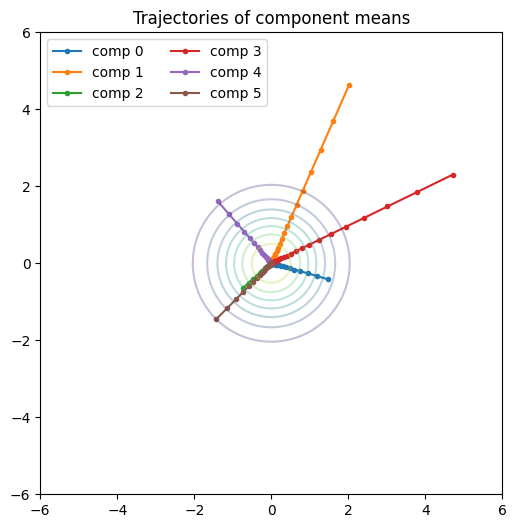

In [11]:
# Plot trajectories of component means
means_history = np.array(means_history)  # (steps+1, N, dim)
plt.figure(figsize=(6,6))
for i in range(N):
    traj = means_history[:, i, :]
    plt.plot(traj[:,0], traj[:,1], '-o', markersize=3, label=f'comp {i}')
plt.contour(Xg, Yg, Z, levels=8, alpha=0.3)
plt.legend(ncol=2)
plt.title('Trajectories of component means')
plt.xlim([-6,6])
plt.ylim([-6,6])
plt.gca().set_aspect('equal')
plt.show()